# Step 3: Time Series Analysis

For monthly predictions, we use time series analysis to estimate when gun violence will go up. In this short notebook, I used Prophet to make time series forcasts. After some experimentation, I found that training on weekly samples and then resampling the forecasts by month gave the best results. Furthermore, there are not enough data points to train on and make annual forecasts.

In [26]:
# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Performance metrics from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Statsmodel for modeling trends
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Prophet for time forecasting
from fbprophet import Prophet

# To hide stdout because Prophet can be loud
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [69]:
# Read in the file
annual_file = './data/cleaned/annual.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'

annual_df = pd.read_csv(annual_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)

In [28]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 12, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# change font
mpl.rcParams['font.family'] = 'Open Sans'

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#6377cb', '#b9bac2'])

In [29]:
def train_prophet(time_series, start=12):
    """Trains the prophet model, making predictions on each value 
    """
    time_series = time_series.reset_index()
    time_series.columns = ['ds', 'y']
    predictions = []
    for i in list(time_series.index)[start:-1]:
        model = Prophet(yearly_seasonality=True)
        model = model.fit(time_series[:i + 2])
        future = model.make_future_dataframe(periods=1)
        output = model.predict(future)
        predictions.append(output.tail(1)[['ds', 'yhat', 'yhat_upper', 'yhat_lower']])

    predictions = pd.concat(predictions).set_index('ds')
    
    return predictions

def plot_predictions(truth, predictions):
    """Plots the truth alongside the predictions and visualize how good the time forecasting model is.
    """
    truth.plot(color='g', label='truth')
    predictions['yhat'].plot(label='predictions')
    predictions['yhat_upper'].plot(color='r', alpha=0.3, ls='--')
    predictions['yhat_lower'].plot(color='r', alpha=0.3, ls='--')
    plt.legend()
    plt.show()

## Weekly Time Series

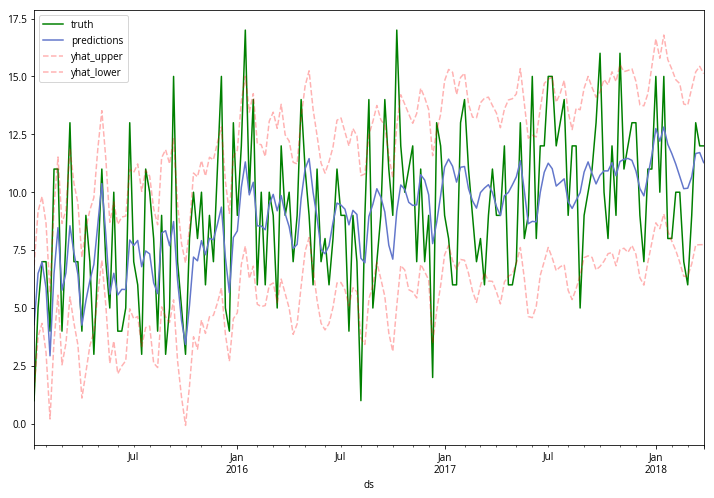

MSE: 7.593441135364075
Aggregated Monthly: 64.64296169767668


In [66]:
# Get weekly time series
start=52
# time_series = by_date_total_df.resample('W').sum().sum(axis=1)
time_series = by_date_total_df.resample('W').sum()
time_series.index = pd.to_datetime(time_series.index)
truth = time_series[start + 1:]

# Make predictions and plot
predictions = train_prophet(time_series, start=start)
plot_predictions(truth, predictions)

# Calculate MSE
print("MSE: {}".format(mean_squared_error(truth, predictions['yhat'])))
print("Aggregated Monthly: {}".format(
    mean_squared_error(truth.resample('M').sum(), predictions['yhat'].resample('M').sum())))

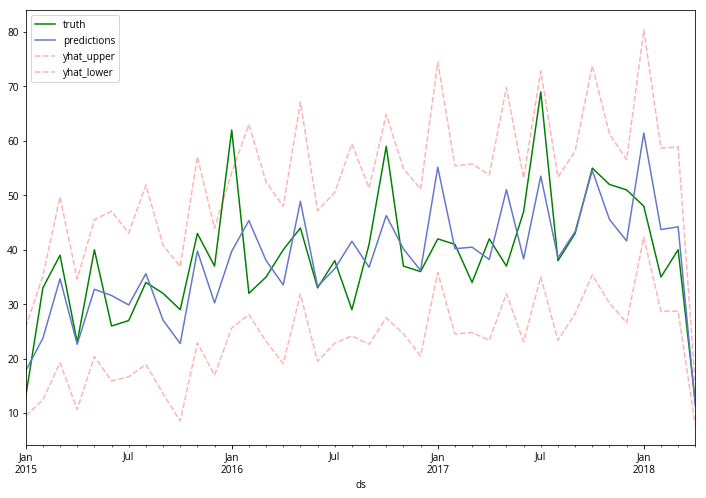

In [67]:
resampled_truth = truth.resample('M').sum()
resampled_preds = predictions.resample('M').sum()

plot_predictions(resampled_truth, resampled_preds)

In [68]:
truth = (resampled_truth - resampled_truth.shift()) / resampled_truth > 0.3
preds = (resampled_preds - resampled_preds.shift())['yhat'] / resampled_preds['yhat'] > 0.3

accuracy_score(truth, preds)

0.80000000000000004

/home/jshuai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


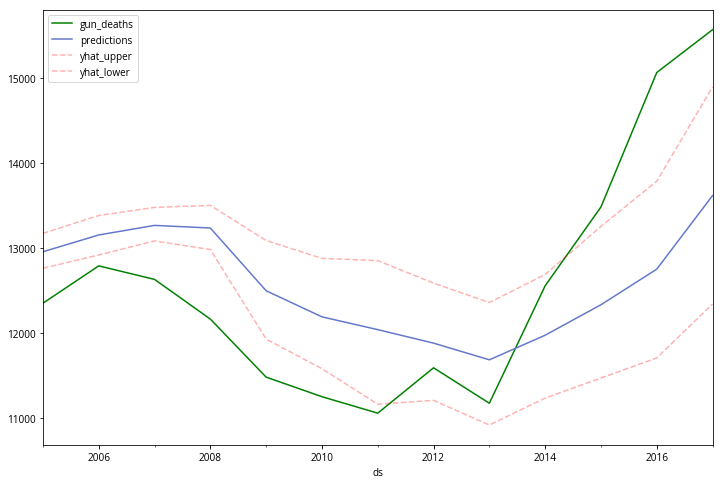

In [95]:
start = 5
time_series = annual_df.groupby('year')[['gun_deaths']].sum()
time_series = time_series.set_index(pd.to_datetime(time_series.index, format='%Y'))
truth = time_series[start + 1:]

predictions = train_prophet(time_series, start=start)
plot_predictions(truth, predictions)